In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys,json,os
sys.path.append('../..')
import Project.profiles as pp
import Project.new_profiles as pnp
from Project.energetics import EI_vdf,Sidm,Dc14
from Project.constants import Constants as pc
from tqdm.notebook import tqdm
import pickle,dill
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
LM = np.linspace(9.,13.,9)
LS = pnp.lmstar_behroozi_19(LM)
C2 = 10**pp.lc200_SR(LM)
RD = 10**(0.28*LS - 2.40)

In [3]:
with open('../Output/data/SIDM_9RCs.pkl', 'rb') as inp:
    sidms = pickle.load(inp)
with open('../Output/data/DC14_9RCs.pkl', 'rb') as inp:
    dc14s = pickle.load(inp)

In [4]:
CP_sidm = json.load(open('../Output/data/SIDM_BNFW_fit.json','r'))
CP_dc14 = json.load(open('../Output/data/DC14_BNFW_fit.json','r'))

In [5]:
def σbym(ρ1,vrel,tage = 10):
    unit = (pc.kpc**3)*1e10/(pc.M_sun*1e3*pc.Gyr*pc.yr)
    return unit/(tage*ρ1*vrel)

In [6]:
for i in range(9):
    s = sidms[i][0]
    print (σbym(s.ρ1,s.σ0*4/np.sqrt(np.pi)))

3.000390754495319
3.000357324370273
3.000013582969704
3.0010013784256864
2.999996057576209
3.0000005402702907
2.9999920466342243
3.000001262729139
2.999998350181844


In [11]:
vdfs = []
for i in tqdm(range(9)):
    s = sidms[i][0]
    cp = CP_sidm[i]
    lm,rs,rc = cp
    ei = pe.EI_vdf({'dm':['core',lm,rs,rc]})
    vdf = ei.get_vdf(rc,n = 30)
    vdfs.append(vdf)

  0%|          | 0/9 [00:00<?, ?it/s]

In [23]:
for i in range(9):
    s = sidms[i][0]
    lm,rs,rc = CP_sidm[i]
    ρrc = pp.density_sidm(lm,rs,rc,rc)
    r_ = np.logspace(-2,np.log10(rc),100)
    ρav = np.trapz(pp.density_sidm(lm,rs,rc,r_)*r_**2,r_)*3/rc**3
    print (ρav/s.ρ1,ρrc/s.ρ1)

1.4714780725282677 0.5824119460206502
1.512716641063065 0.5949247477705282
1.6271671491284343 0.6410862932829665
1.979135415054969 0.7995520164328144
3.2915640023764015 1.4436856077300586
9.902229802099436 5.110097524475032
35.24743424598851 20.24924015861175
47.66808349931926 28.00952525364738
25.8922602658804 14.772797392685925


In [9]:
for i in range(9):
    s = sidms[i][0]
    vdf = vdfs[i]
    vrms = np.sqrt(np.trapz(vdf[:,0]**2 * vdf[:,1],vdf[:,0])/3.)
    print (s.σ0, vrms)

12.165396370617165 12.919149508624374
17.39205017476779 18.36407347098162
24.963775496953573 26.16784758538332
36.13466478895358 37.465453674406255
53.2897706086035 53.983966202766325
81.3800087344915 76.38954204287629
124.98921488988164 104.00706594290902
174.96708174445163 145.47377918275035
237.49011292661268 214.47935644125084


In [10]:
for i in range(9):
    vdf = vdfs[i]
    vavg = np.trapz(vdf[:,0]*vdf[:,1],vdf[:,0])
    vrel = vavg*np.sqrt(2)
    ρrc = pp.density_sidm(lm,rs,rc,rc)
    print (σbym(ρrc,vrel))

3.6983651244330282
2.6013328851580164
1.825610939809068
1.2760470081044994
0.8880900676697047
0.6335152762925395
0.4717904705950261
0.3389982561479744
0.22848137311323133


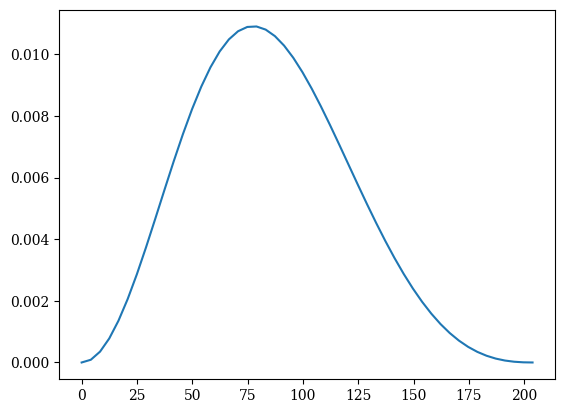

In [25]:
lm,rs = 11,10
cusp = EI_vdf({'dm':['cusp',lm,rs]})
vdf_cusp = cusp.get_vdf(10,n = 50)
plt.plot(vdf_cusp[:,0],vdf_cusp[:,1])

# Maxwell-Boltzmann distriubtion

In [15]:
def MB(v,*args):
    m,k,T = args
    return ((m/(2*np.pi*k*T))**(3/2))*4*np.pi*v**2 * np.exp(-m*v**2/(2*k*T))

0.9999611700111891


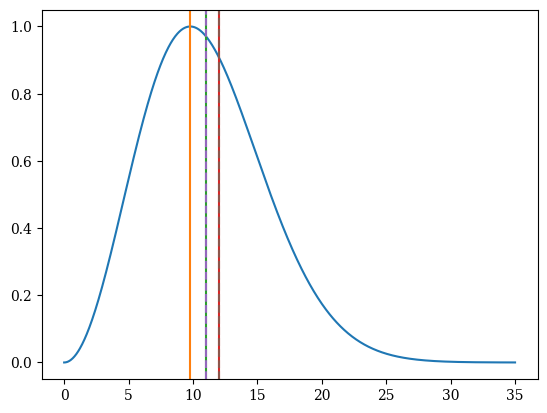

In [16]:
args = [1.67*1e-27,1.380*1e-29,5800]
m,k,T = args
v = np.linspace(0,35,1000)
solar = MB(v,*args)
fig,ax = plt.subplots()
ax.plot(v,solar/np.max(solar))
ylim = ax.get_ylim()
vp = np.sqrt(2*k*T/m)
ax.plot([vp,vp],ylim)
vmean = np.sqrt(8*k*T/np.pi/m)
ax.plot([vmean,vmean],ylim)
vrms = np.sqrt(3*k*T/m)
ax.plot([vrms,vrms],ylim)
ax.set_ylim(ylim)

vavg = np.trapz(v*solar,v)
ax.plot([vavg,vavg],ylim,ls = '--')

v0 = np.sqrt(np.trapz(v**2 * solar, v))

ax.plot([v0,v0],ylim,ls = '--')

sig0 = vrms/np.sqrt(3)
print (np.sqrt(2)*vavg / (4*sig0/np.sqrt(np.pi)))

# Distinguishing DC14, SIDM using BNFW
## (i)   Residual plots: Velocity and density profiles  
## (ii)  C200 comparision
## (iii) VDF comparison

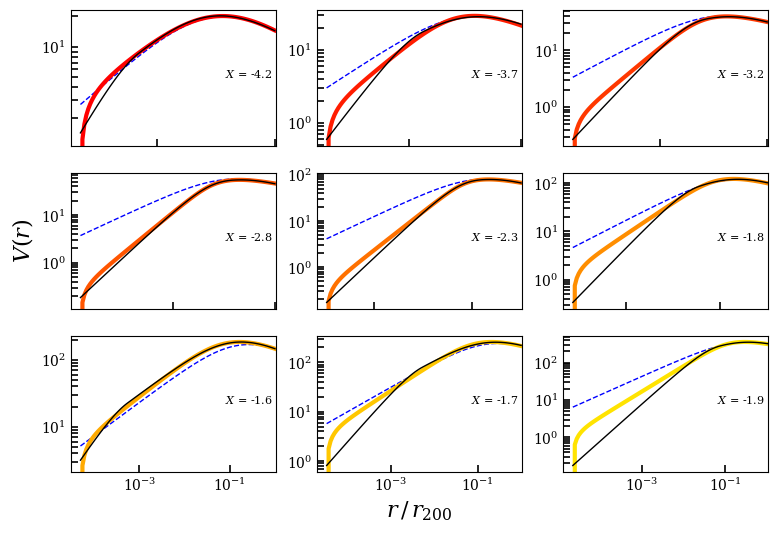

In [49]:
fig,axs = plt.subplots(3,3,figsize = (9,6))
axs = axs.flatten()
cmap1,cmap2 = plt.get_cmap('autumn'),plt.get_cmap('summer')
key = ['dc14']
show_inset = False
for i in range(9):
    dc14,sidm = dc14s[i],sidms[i][0]
    ax = axs[i]
    cmap_1,cmap_2 = cmap1(i/9.),cmap2(i/9.)
    lm,ls,c2 = LM[i],LS[i],C2[i]
    r200 = pp.r200_nfw(lm)
    rs_nfw = r200/c2
    r = np.logspace(-2,np.log10(r200),100)
    vdc14 = dc14.v_dc14(r)
    vsidm = sidm.v_kap(r)
    vnfw = pp.v_nfw(lm,rs_nfw,r)
    cp_dc14 = CP_dc14['vels'][i]
    cp_sidm = CP_sidm['vels'][i]
    vbnfw_d = pp.v_sidm(*cp_dc14[:3],r)
    vbnfw_s = pp.v_sidm(*cp_sidm[:3],r)

    ax.plot(r/r200,vnfw,color = 'b', lw = 1, ls = '--')
    if 'sidm' in key:
        ax.plot(r/r200,vsidm,color = cmap_2, lw = 3)
        ax.plot(r/r200,vbnfw_s,color = 'k', lw = 1)
    if 'dc14' in key:
        ax.plot(r/r200,vdc14,color = cmap_1, lw = 3)
        ax.plot(r/r200,vbnfw_d,color = 'k', lw = 1)
        
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(-0.05,1.05)
    if i in [0,1,2,3,4,5]: ax.set_xticklabels([])
    if i == 3: ax.set_ylabel('$V(r)$',size = 16)
    if i == 7: ax.set_xlabel('$r\,/\,r_{200}$',size = 16)
    ax.tick_params(which = 'both',direction = 'in',width = 1.2, length = 5)
    
    if show_inset:
        inset_ax = inset_axes(ax,
                            width="70%",
                            height=.7,
                            bbox_to_anchor = (-0.05,-0.3,0.8,1),
                            bbox_transform = ax.transAxes)

        inset_ax.plot(r/r200,vnfw,color = 'k',lw = 1,ls = '--')
        if 'dc14' in key:
            inset_ax.plot(r/r200,vdc14,color = cmap_1, lw = 3)
            inset_ax.plot(r/r200,vbnfw_d,color = 'k', ls = '-', lw = 1)
        if 'sidm' in key:
            inset_ax.plot(r/r200,vsidm,color = cmap_2, lw = 3)
            inset_ax.plot(r/r200,vbnfw_s,color = 'k', ls = '-', lw = 1)

        inset_ax.set_xlim(0,0.11)
        inset_ax.tick_params(which = 'both', direction = 'in',labelsize = 8)
        inset_ax.set_xticks([0,0.1])
        inset_ax.set_xticklabels([0,0.1])
    
    ax.text(0.75,0.5,'$X$ = %.1f'%(ls-lm),size = 8,transform = ax.transAxes)
    
# plt.savefig('../Output/figures/comparison/DC14_RC.pdf',bbox_inches = 'tight',dpi = 300)

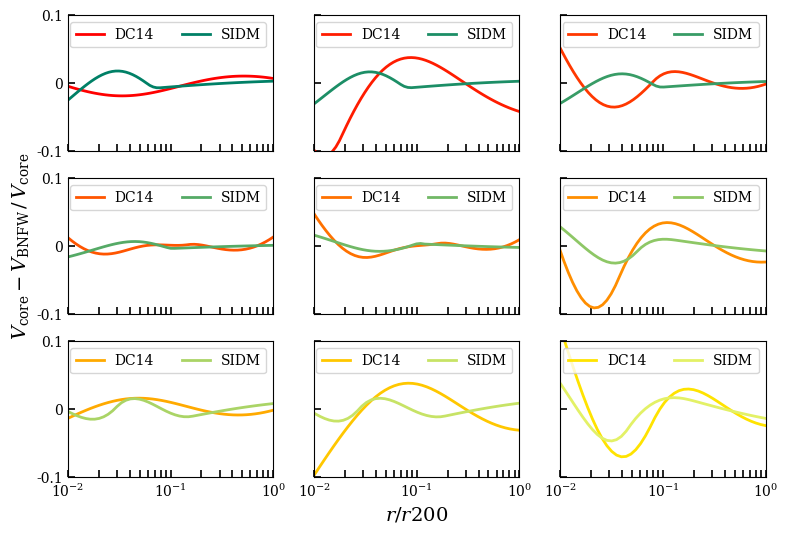

In [116]:
fig,axs = plt.subplots(3,3,figsize = (9,6))
axs = axs.flatten()
key = ['sidm']
for i in range(9):
    dc14,sidm = dc14s[i],sidms[i][0]
    ax = axs[i]
    cmap_1,cmap_2 = cmap1(i/9.),cmap2(i/9.)
    cp_d = CP_dc14['vels'][i]
    cp_s = CP_sidm['vels'][i]
    r200 = dc14.r200
    r = np.logspace(-2,np.log10(r200),100)
    vsidm = sidm.v_kap(r)
    vdc14 = dc14.v_dc14(r)
    vnfw = sidm.v_nfw(r)
    vbnfw_d = pp.v_sidm(*cp_d[0:3],r)
    vbnfw_s = pp.v_sidm(*cp_s[0:3],r)
    diff_d = (vdc14 - vbnfw_d)/vdc14
    diff_s = (vsidm - vbnfw_s)/vsidm
    ax.plot(r/r200, diff_d, color = cmap_1, lw = 2,label = 'DC14')
    ax.plot(r/r200, diff_s, color = cmap_2, lw = 2,label = 'SIDM')
    ax.set_xscale('log')
    ax.set_xlim(1e-2,1e0)
    ax.set_ylim(-0.1,0.1)
    ax.legend(ncols = 2)
    
    ax.set_yticks([-0.1,0,0.1])
    if not i%3: ax.set_yticklabels([-0.1,0,0.1])
    else: ax.set_yticklabels([])
    if not i in [6,7,8]: ax.set_xticklabels([])
    ax.tick_params(which = 'both',direction = 'in', width = 1.2, length = 5)
    
    if i == 7: ax.set_xlabel(r'$r/r200$',size = 14)
    if i == 3: ax.set_ylabel('$V_{\mathrm{core}}-V_{\mathrm{BNFW}}\,/\,V_{\mathrm{core}}$',size = 14)
    
plt.savefig('../Output/figures/comparison/residual_vels_%s.pdf'%key,bbox_inches = 'tight',dpi = 300)

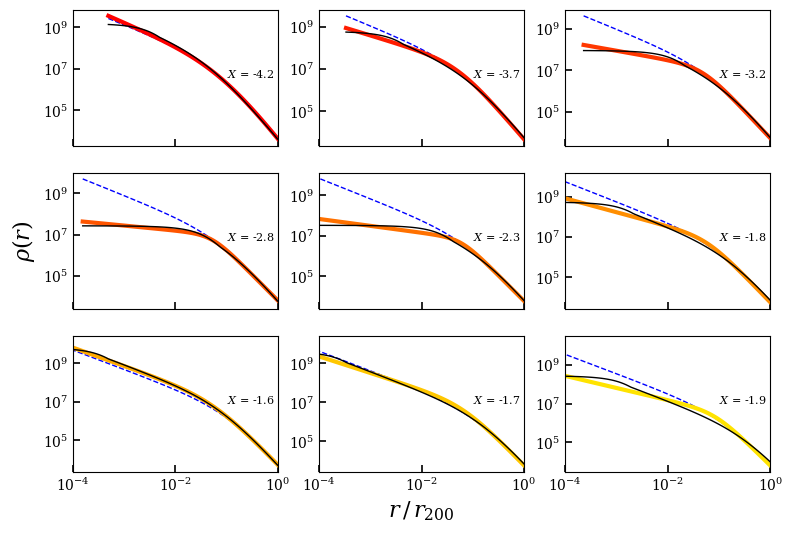

In [92]:
fig,axs = plt.subplots(3,3,figsize = (9,6))
axs = axs.flatten()
cmap1,cmap2 = plt.get_cmap('autumn'),plt.get_cmap('summer')
key = ['dc14']
for i in range(9):
    dc14,sidm = dc14s[i],sidms[i][0]
    ax = axs[i]
    cmap_1,cmap_2 = cmap1(i/9.),cmap2(i/9.)
    lm,ls,c2 = LM[i],LS[i],C2[i]
    r200 = pp.r200_nfw(lm)
    rs_nfw = r200/c2
    r = np.logspace(-2,np.log10(r200),100)
    ρdc14 = dc14.ρ_dc14(r)
    ρsidm = sidm.ρ_kap(r)
    ρnfw = pp.density_nfw(lm,rs_nfw,r)
    cp_dc14 = CP_dc14['dens'][i]
    cp_sidm = CP_sidm['dens'][i]
    ρbnfw_d = pp.density_sidm(*cp_dc14[:3],r)
    ρbnfw_s = pp.density_sidm(*cp_sidm[:3],r)

    ax.plot(r/r200,ρnfw,color = 'b', lw = 1, ls = '--')
    if 'sidm' in key:
        ax.plot(r/r200,ρsidm,color = cmap_2, lw = 3)
        ax.plot(r/r200,ρbnfw_s,color = 'k', lw = 1)
    if 'dc14' in key:
        ax.plot(r/r200,ρdc14,color = cmap_1, lw = 3)
        ax.plot(r/r200,ρbnfw_d,color = 'k', lw = 1)
        
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-4,1)
    if i in [0,1,2,3,4,5]: ax.set_xticklabels([])
    if i == 3: ax.set_ylabel(r'$\rho(r)$',size = 16)
    if i == 7: ax.set_xlabel('$r\,/\,r_{200}$',size = 16)
    ax.tick_params(which = 'both',direction = 'in',width = 1.2, length = 5)
    
    ax.text(0.75,0.5,'$X$ = %.1f'%(ls-lm),size = 8,transform = ax.transAxes)
    
# plt.savefig('../Output/figures/comparison/DC14_RC.pdf',bbox_inches = 'tight',dpi = 300)

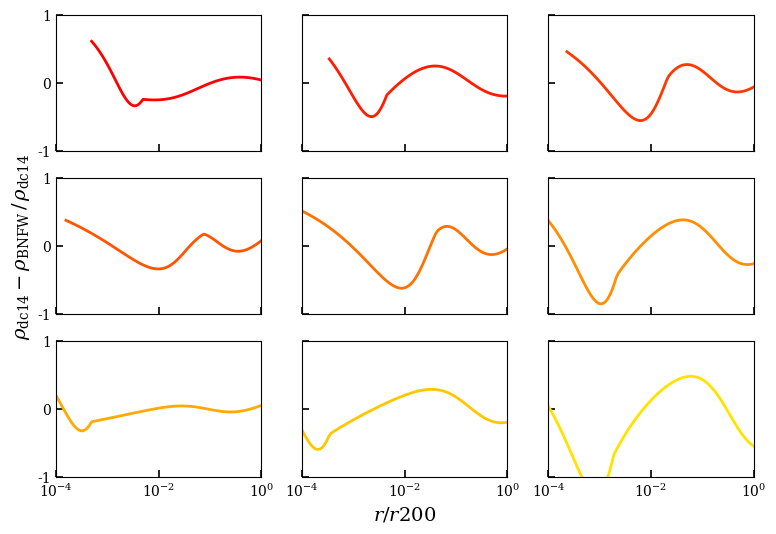

In [120]:
fig,axs = plt.subplots(3,3,figsize = (9,6))
axs = axs.flatten()
key = ['dc14']
for i in range(9):
    dc14,sidm = dc14s[i],sidms[i][0]
    ax = axs[i]
    cmap_1,cmap_2 = cmap1(i/9.),cmap2(i/9.)
    cp_d = CP_dc14['dens'][i]
    cp_s = CP_sidm['dens'][i]
    r200 = dc14.r200
    r = np.logspace(-2,np.log10(r200),100)
    ρsidm = sidm.ρ_kap(r)
    ρdc14 = dc14.ρ_dc14(r)
    ρnfw = sidm.ρ_nfw(r)
    ρbnfw_d = pp.density_sidm(*cp_d[0:3],r)
    ρbnfw_s = pp.density_sidm(*cp_s[0:3],r)
    diff_d = (ρdc14 - ρbnfw_d)/ρdc14
    diff_s = (ρsidm - ρbnfw_s)/ρsidm
    if 'dc14' in key:
        ax.plot(r/r200, diff_d, color = cmap_1, lw = 2,label = 'DC14')
    if 'sidm' in key:
        ax.plot(r/r200, diff_s, color = cmap_2, lw = 2,label = 'SIDM')

    ax.set_xscale('log')
    ax.set_xlim(1e-4,1e0)
    
    if 'sidm' in key:
        ax.set_ylim(-0.15,0.15)
        ylim = ax.get_ylim()
        ax.plot([sidm.r1/r200]*2,ylim, color = cmap_2, label = 'r1',ls = '--')
        ax.plot([cp_s[2]/r200]*2,ylim, c = 'k', ls = '--', label = 'rc')
        ax.text(0.9,0.9, '$r_1$', color = cmap_2, transform = ax.transAxes)
        ax.text(0.9,0.8, '$r_c$', color = 'k',transform = ax.transAxes)
        ax.set_ylim(ylim)
        yticks = [-0.1,0,0.1]

        
    if 'dc14' in key:
        ax.set_ylim(-1,1)
        yticks = [-1,0,1]

    ax.set_yticks(yticks)
    if not i%3: ax.set_yticklabels(yticks)
    else: ax.set_yticklabels([])
    if not i in [6,7,8]: ax.set_xticklabels([])
    ax.tick_params(which = 'both',direction = 'in', width = 1.2, length = 5)
    
    if i == 7: ax.set_xlabel(r'$r/r200$',size = 14)
    if i == 3: ax.set_ylabel(r'$\rho_{\mathrm{%s}}-\rho_{\mathrm{BNFW}}\,/\,\rho_{\mathrm{%s}}$'%(key[0],key[0]),size = 14)
    
plt.savefig('../Output/figures/comparison/residual_dens_%s.pdf'%key,bbox_inches = 'tight',dpi = 300)

In [29]:
VDF_dc14s,VDF_sidms = [],[]
for i in tqdm(range(9)):
    lm,c2,ls,rd = LM[i],C2[i],LS[i],RD[i]
    dc14,sidm = dc14s[i],sidms[i][0]
    r200 = dc14.r200
    rs = r200/c2
    r = np.logspace(-2,np.log10(r200),30)
    ei_dc14 = EI_vdf({'dm':['dc14',dc14.ρ_dc14]})
    ei_sidm = EI_vdf({'dm':['sidm',sidm.ρ_kap]})
    VDF_dc14,VDF_sidm = [],[]
    for ri in tqdm(r):
        VDF_dc14.append(ei_dc14.get_vdf(ri,n=50))
        VDF_sidm.append(ei_sidm.get_vdf(ri,n=50))
    VDF_dc14s.append(VDF_dc14)
    VDF_sidms.append(VDF_sidm)

  0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [30]:
VDF_dc14[0]

array([[ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan]])

In [33]:
i = 0
lm,c2,ls,rd = LM[i],C2[i],LS[i],RD[i]
dc14,sidm = dc14s[i],sidms[i][0]
r200 = dc14.r200
rs = r200/c2
r = np.logspace(-2,np.log10(r200),30)
ei_dc14 = EI_vdf({'dm':['dc14',dc14.ρ_dc14]})
# ei_sidm = EI_vdf({'dm':['sidm',sidm.ρ_kap]})

In [37]:
ei_sidm = EI_vdf({'dm':['sidm',sidm.ρ_kap]})

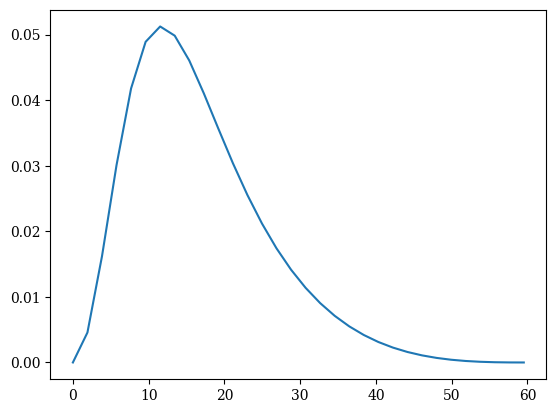

In [36]:
vdf = ei_dc14.get_vdf(r[10])
plt.plot(vdf[:,0],vdf[:,1])

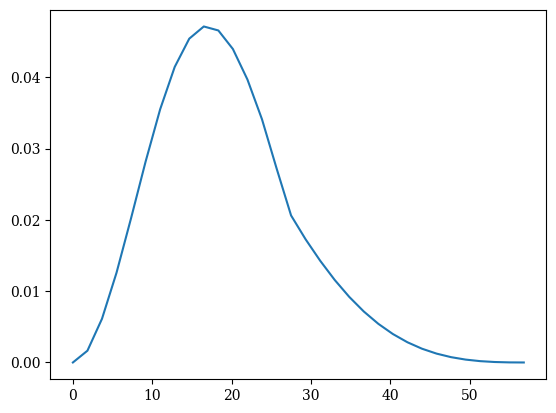

In [38]:
vdf = ei_sidm.get_vdf(r[10])
plt.plot(vdf[:,0],vdf[:,1])